In [34]:
#Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
import pandas as pd 
import matplotlib.pyplot as plt
import datetime

In [2]:
#Connect to the database, define Base class
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)

In [3]:
#Confirm that there are two tables in the database
Base.classes.keys()

['measurements_table', 'stations_table']

In [4]:
#Set to variables
Measurements = Base.classes.measurements_table
Stations = Base.classes.stations_table

In [5]:
#Connect the engine and start the session
session = Session(engine)
conn = engine.connect()

In [6]:
#Create a dataframe corresponding only to data taken in the last year by manually defining the last date in the dataset, and counting back one year from
#that date. (If we used today's date instead of the last date in the data, there would only be 6 dates in the dataframe because it ends in May 2017)
twelve_months_date =  datetime.date(2017 , 5, 13) - datetime.timedelta(365)
tmd = str(twelve_months_date)
print(tmd)
last_twelve_months_df = pd.read_sql("SELECT date, prcp FROM measurements_table WHERE date > '{}' ".format(tmd), conn)
last_twelve_months_df.head()

2016-05-13


,date,prcp
0,2016-05-14,0.00
1,2016-05-15,0.02
2,2016-05-16,0.00
3,2016-05-17,0.00
4,2016-05-18,0.00


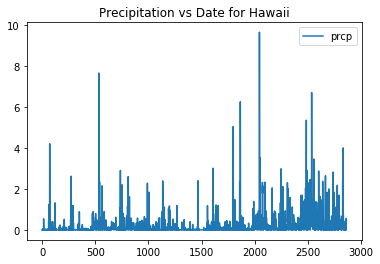

In [7]:
#Plot using Pandas DataFrame Plot method.
last_twelve_months_df.plot(kind='line', title='Precipitation vs Date for Hawaii', legend='Precipitation')

In [8]:
#Summary statistics for last years precipitation dataframe
last_twelve_months_df.describe()

,prcp
count,2864.000000
mean,0.177689
std,0.505796
min,0.000000
25%,0.000000
50%,0.010000
75%,0.130000
max,9.640000


In [11]:
#Number of stations in Hawaii
station_number_df = pd.read_sql("SELECT * FROM stations_table", conn)
number_of_stations = len(station_number_df['station'])
print(number_of_stations)

9


In [12]:
#The next two cells test the method I will use to find the most popular station over the last year. In these cells I find the most
#popular station for the overall data and use the results as a reference going forward.


#Get all stations, remove all duplicates to get the total number of stations with their names
station_obs_df = pd.read_sql("SELECT station from measurements_table", conn)
station_names = station_obs_df['station'].unique()

#List to store the number of observations for each station
stations_list_counts = [0 for y in range(0, len(station_names))]

#Iterate through all stations numerically (I experienced difficulties using list comprehension for this loop)
for x in range(0,len(station_names)):
    #initialize or reset the counter to 0
    counter=0
    #Iterate over all observation data searching for observations made by the specific station we have picked in the above for loop
    for station in station_obs_df['station']:
        #if an opservation was taken by the above station, increase the counter by 1
        if station == str(station_names[x]):
            counter=counter+1
    #After iterating over all observations, append the current counter value to the count list and move on to the next station
    stations_list_counts[x] = counter
#Print the results
print(station_names)
print(stations_list_counts)
#Put them into a dictionary and convert to a dataframe
test_dict = {
    "station": station_names,
    "obs count": stations_list_counts
}
obs_count_df = pd.DataFrame(test_dict)
obs_count_df = obs_count_df.sort_values(by=['obs count'], ascending=False)
obs_count_df

['USC00519397' 'USC00513117' 'USC00514830' 'USC00517948' 'USC00518838'
 'USC00519523' 'USC00519281' 'USC00511918' 'USC00516128']
[2724, 2709, 2202, 1372, 511, 2669, 2772, 1979, 2612]


,obs count,station
6,2772,USC00519281
0,2724,USC00519397
1,2709,USC00513117
5,2669,USC00519523
8,2612,USC00516128
2,2202,USC00514830
7,1979,USC00511918
3,1372,USC00517948
4,511,USC00518838


In [15]:
#Redefine the index of the above dataframe (the dataframe above has index values that are not in order now that the list is sorted
index1 = [z for z in range(0, len(station_names))]
print(index1)
obs_count_df['index1'] = index1
sorted_count_df = obs_count_df.set_index('index1')
#Display the new frame that has been indexed in descending order
sorted_count_df.head()
#Use the new index to find the most popular station by looking for the station with index 0
popstation = sorted_count_df['station'][0]
#Most popular station result
print(popstation)

[0, 1, 2, 3, 4, 5, 6, 7, 8]
USC00519281


In [16]:
#Query for only data corresponding to the last year of collected data
sobs_last_year = pd.read_sql("SELECT station, date FROM measurements_table WHERE date > '{}' and station == '{}' ".format(tmd, popstation), conn)
sobs_last_year.head()

,station,date
0,USC00519281,2016-05-14
1,USC00519281,2016-05-15
2,USC00519281,2016-05-16
3,USC00519281,2016-05-17
4,USC00519281,2016-05-18


In [17]:
#The end date in our year range is tmd2, the start date is twelve-months-date
tmd2 = str(twelve_months_date+datetime.timedelta(365))
print(tmd2)
print(twelve_months_date)
#Create a new dataframe corresponding only to the data taken between those two dates
bin_df = pd.read_sql("Select station, date, tobs FROM measurements_table WHERE '{}' < date and date < '{}' ".format(tmd, tmd2), conn)
#Check total number of observations
print(len(bin_df['station']))

2017-05-13
2016-05-13
2282


In [18]:
#Display Dataframe (tobs was converted to a float as it was inserted into the databse because the integer was too big to be read into a column using
#sqlalchemy Integer method)
bin_df.head()

,station,date,tobs
0,USC00519397,2016-05-14,77.0
1,USC00519397,2016-05-15,78.0
2,USC00519397,2016-05-16,77.0
3,USC00519397,2016-05-17,78.0
4,USC00519397,2016-05-18,79.0


In [20]:
#Exact replica of the method used above to find the most popular station. Many of the variables are simply renamed with an extra 1.
#The only difference is that this method was only run on the data from the last year (bin_df)
station_names1 = bin_df['station'].unique()

stations_list_counts1 = [0 for y in range(0, len(station_names1))]
for x in range(0,len(station_names1)):
    counter=0
    
    for station in bin_df['station']:
        if station == str(station_names1[x]):
            counter=counter+1   
    stations_list_counts1[x] = counter
print(station_names1)
print(stations_list_counts1)
test_dict1 = {
    "station": station_names1,
    "obs count": stations_list_counts1
}
obs_count_df1 = pd.DataFrame(test_dict1)
obs_count_df1 = obs_count_df1.sort_values(by=['obs count'], ascending=False)
obs_count_df1

['USC00519397' 'USC00513117' 'USC00514830' 'USC00517948' 'USC00519523'
 'USC00519281' 'USC00516128']
[363, 364, 303, 207, 340, 364, 341]


,obs count,station
1,364,USC00513117
5,364,USC00519281
0,363,USC00519397
6,341,USC00516128
4,340,USC00519523
2,303,USC00514830
3,207,USC00517948


In [21]:
#Identical re-indexing method from above to get the most popular station
index2 = [z for z in range(0, len(station_names1))]
print(index2)
obs_count_df1['index2'] = index2

sorted_count_df1 = obs_count_df1.set_index('index2')
sorted_count_df1.head()
popstation1 = sorted_count_df1['station'][0]
print(popstation1)

[0, 1, 2, 3, 4, 5, 6]
USC00513117


In [22]:
#Create a series of bins corresponding to approximately 1 month of data (used to create histogram)
bins = []
current_date = twelve_months_date
for t in range(0, 13):
    bins.append(current_date)
    current_date = current_date+datetime.timedelta(30)
#Verify bins and length of bins list
print(bins)    
print(len(bins))

[datetime.date(2016, 5, 13), datetime.date(2016, 6, 12), datetime.date(2016, 7, 12), datetime.date(2016, 8, 11), datetime.date(2016, 9, 10), datetime.date(2016, 10, 10), datetime.date(2016, 11, 9), datetime.date(2016, 12, 9), datetime.date(2017, 1, 8), datetime.date(2017, 2, 7), datetime.date(2017, 3, 9), datetime.date(2017, 4, 8), datetime.date(2017, 5, 8)]
13


In [36]:
#Dataframe corresponding to the last year of data, taken solely by the station with the highest number of observations for that  year
popstation_bin_df = pd.read_sql("Select station, date, tobs FROM measurements_table WHERE '{}' < date and date < '{}' and station = '{}' ".format(tmd, tmd2, popstation1), conn)
popstation_bin_df.head()

,station,date,tobs
0,USC00513117,2016-05-14,72.0
1,USC00513117,2016-05-15,74.0
2,USC00513117,2016-05-16,75.0
3,USC00513117,2016-05-17,75.0
4,USC00513117,2016-05-18,74.0


In [24]:
#Lists to hold the x and y values for the histogram
mean_monthly_temperatures_list = []
months_list = []
#List to hold the dates above to make code easier to read below
dates_list = popstation_bin_df['date']

#Loop through all bins (months)
for m in range(0, 12):
    #Assign a start and end date for the given segment
    date1 = str(bins[m]) < dates_list
    date2 = dates_list < str(bins[m+1])
    #Create a new dataframe with the data from that month inside
    month_df = popstation_bin_df[date1]
    month_df = month_df[date2]
    
    #append mean temperature to the list of y values for the histogram
    mean_monthly_temperature = int(month_df['tobs'].mean())
    mean_monthly_temperatures_list.append(mean_monthly_temperature)
    #Append integer list of x values for the histogram
    months_list.append(m+1)
#Print out the x and y values
print(mean_monthly_temperatures_list)
print(months_list)

[73, 75, 76, 76, 76, 75, 73, 69, 69, 69, 72, 72]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


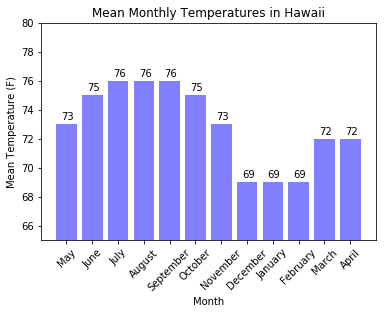

In [26]:
#Create bar graph
plt.bar(months_list, mean_monthly_temperatures_list, color='b', alpha=0.5, align="edge")
#Set tick locations and x-axis labels then put the ticks on the graph
tick_locations = [value+0.4 for value in months_list]
month_labels_list = ['May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February', 'March', 'April']
plt.xticks(tick_locations, month_labels_list, rotation=45)
#Set ylimits to make the monthly differences more clear
plt.ylim(65, 80)
#Add title and axes labels
plt.title("Mean Monthly Temperatures in Hawaii")
plt.xlabel("Month")
plt.ylabel("Mean Temperature (F)")

#Loop through each bar in the graph and place its corresponding y value directly above the bar
for t in range(0, len(months_list)):
    plt.text(tick_locations[t]-0.2, mean_monthly_temperatures_list[t]+0.3, str(mean_monthly_temperatures_list[t]))
#Save and display the figure
plt.savefig('temperatures_histogram')
plt.show()

In [38]:
#Create a dataframe with station, date and tobs data from all dates and stations
full_df = pd.read_sql("Select station, date, tobs FROM measurements_table", conn)
#Save the dates into a list to make the code cleaner below
trip_dates_list = full_df['date']
full_df.to_csv('fulldata.csv')
full_df.head()

,station,date,tobs
0,USC00519397,2010-01-01,65.0
1,USC00519397,2010-01-02,63.0
2,USC00519397,2010-01-03,74.0
3,USC00519397,2010-01-04,76.0
4,USC00519397,2010-01-06,73.0


In [30]:
#Define calc_temps function which takes a start and end date and returns all data within the date range
def calc_temps(start_date, end_date):
    # <= and >= used to solve issues where the vacation date is only 1 day
    df_start_date = start_date <= trip_dates_list
    df_end_date = trip_dates_list <= end_date
    #Return the dataframe for the corresponding date range
    calc_temps_df = full_df[df_start_date]
    calc_temps_df = calc_temps_df[df_end_date]
    #Create a list to calculate the min, average and max temperatures
    temps_list = calc_temps_df['tobs']
    mintemp = temps_list.min() 
    avgtemp = temps_list.mean()
    maxtemp = temps_list.max()
    #Return calculated values
    return mintemp, avgtemp, maxtemp;

In [ ]:
#Create a second calc_temps method used in one of the paths in the flask api

#Define calc_temps function which takes a start and end date and returns all data within the date range
def calc_temps1(start_date):
    # <= and >= used to solve issues where the vacation date is only 1 day
    df_start_date = start_date <= trip_dates_list
    #Return the dataframe for the corresponding date range
    calc_temps_df = full_df[df_start_date]
    #Create a list to calculate the min, average and max temperatures
    temps_list = calc_temps_df['tobs']
    mintemp = temps_list.min() 
    avgtemp = temps_list.mean()
    maxtemp = temps_list.max()
    #Return calculated values
    return mintemp, avgtemp, maxtemp;

In [31]:
#Define inputs and create a list to store the returned values
start_date = input("Enter your start date: YYYY-MM-DD e.g. 2015-02-07    ")
end_date = input("Enter your end date: YYYY-MM-DD e.g. 2015-02-09    ")
temprange_values_list = calc_temps(start_date, end_date)
#Call calc_temps
calc_temps(start_date, end_date)

Enter your start date: YYYY-MM-DD e.g. 2015-02-07    2017-02-09
Enter your end date: YYYY-MM-DD e.g. 2015-02-09    2017-02-15


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(59.0, 70.6086956521739, 80.0)

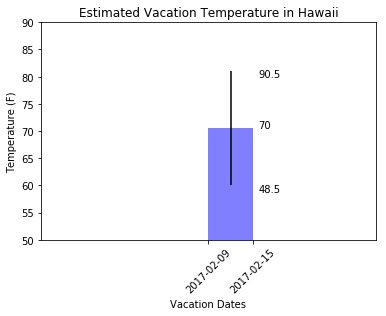

In [33]:
#Since there is only one bar I set the x value to 3 and the range from 0 to 6 to place the bar near the center and have it not take up too much space
x_axis = [3]
#Define peak to peak value to calculate error
y_peak_to_peak = temprange_values_list[2] - temprange_values_list[0]
#Error is half of the peak to peak value
y_error = y_peak_to_peak/2
#Create bar graph, set error to be +/- half of the peak to peak value
plt.bar(x_axis, temprange_values_list[1], color='b', alpha=0.5, align="edge", yerr=y_error)
#Manually define tick locations since we need two x values but only have 1 y value
tick_locations = [3, 3.8]
#Label the start and end of the bar with the start and end vacation dates
plt.xticks(tick_locations, [start_date, end_date], rotation=45)
#Modify x and y limits to make the graph easier to read
plt.xlim(0, 6)
plt.ylim(50, 90)
#Add title and axis labels
plt.title("Estimated Vacation Temperature in Hawaii")
plt.xlabel("Vacation Dates")
plt.ylabel("Temperature (F)")

#Loop through all bars (only 1 bar) and add mean, and upper and lower error bar values
for t in range(0, len(x_axis)):
    plt.text(tick_locations[t]+0.9, temprange_values_list[1], str(int(temprange_values_list[1])))
    plt.text(tick_locations[t]+0.9, temprange_values_list[0]-0.3, str(int(temprange_values_list[0])-y_error))
    plt.text(tick_locations[t]+0.9, temprange_values_list[2], str(int(temprange_values_list[2])+y_error))
#save and show figure
plt.savefig('vacation_temperature_with_error')
plt.show()

In [ ]:
#All flask code is in the flask_api_website2.py file